In [ ]:
!pip install torchmetrics
!pip install albumentations
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import zipfile
import json
from PIL import Image
from tqdm import tqdm
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

#미션 1-2
import io
import cv2
from torchvision import models, transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import albumentations as A # 설치 필요
from albumentations.pytorch import ToTensorV2
import torchmetrics # 설치 필요
from torch.optim.lr_scheduler import StepLR

## 미션 3-1
from sklearn.metrics import pairwise_distances
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
pd.options.mode.chained_assignment = None

## 미션 3-2
from sklearn.metrics.pairwise import cosine_similarity
from io import BytesIO
import optuna # 설치 필요

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# ***미션 1 : ResNet-18을 이용한 패션 스타일 이미지 분류***
---

## 미션 1-1
- 주어진 이미지 데이터의 파일 명
  -  “{W/T}_{이미지ID}_{시대별}_{스타일별}_{성별}.jpg”
- 이에 기반해 “이미지ID” 수 기준 “성별 & 스타일” 통계치 기입
- Training, Validation 데이터에 대해서 각각 통계표 작성

### **1) 압축 파일 내부 데이터 확인**

훈련 데이터 경로 - training_image/ 으로 시작
<br>
검증 데이터 경로 - validation_image/ 으로 시작

In [ ]:
#traing_image
zip_file_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

with zipfile.ZipFile('/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip','r') as zip_file:
    file_list = zip_file.namelist()

    train_file_list = [file for file in file_list if file.startswith('training_image/')]
    valid_file_list = [file for file in file_list if file.startswith('validation_image/')]

In [ ]:
# 데이터셋에서의 첫 번째 파일의 이름 출력
print(train_file_list[0])
print(valid_file_list[0])

training_image/
validation_image/


### **2) 이미지 파일 성별 분류**

훈련, 검증 데이터에 상관없이 파일명 마지막 5글자는 성별을 의미함

In [ ]:
train_file_list[1][-5:]

'W.jpg'

In [ ]:
# 학습 데이터셋에서 'W.jpg'로 끝나는 여성 이미지 파일 필터링
w_train_file_list = [file for file in train_file_list if file[-5:] == 'W.jpg']
# 검증 데이터셋에서 'W.jpg'로 끝나는 여성 이미지 파일 필터링
w_valid_file_list = [file for file in valid_file_list if file[-5:] == 'W.jpg']
# 학습 데이터셋에서 'M.jpg'로 끝나는 남성 이미지 파일 필터링
m_train_file_list = [file for file in train_file_list if file[-5:] == 'M.jpg']
# 검증 데이터셋에서 'M.jpg'로 끝나는 남성 이미지 파일 필터링
m_valid_file_list = [file for file in valid_file_list if file[-5:] == 'M.jpg']

### **3) 성별, 이미지별 패션 스타일 분류**

훈련, 검증 데이터에 상관없이 파일명의 26번째 인덱스부터 시작하여 마지막 6글자를 제외하면 패션 스타일을 의미함

In [ ]:
train_file_list[1][26:][:-6]

'feminine'

In [ ]:
# 학습 데이터셋에서 여성 이미지 파일 이름에서 경로를 제외하고 스타일-성별 부분만 추출
w_train_file_name = [file[26:][:-6] for file in w_train_file_list]
# 검증 데이터셋에서 여성 이미지 파일 이름에서 경로를 제외하고 스타일-성별 부분만 추출
w_valid_file_name = [file[28:][:-6] for file in w_valid_file_list]
# 학습 데이터셋에서 남성 이미지 파일 이름에서 경로를 제외하고 스타일-성별 부분만 추출
m_train_file_name = [file[26:][:-6] for file in m_train_file_list]
# 검증 데이터셋에서 남성 이미지 파일 이름에서 경로를 제외하고 스타일-성별 부분만 추출
m_valid_file_name = [file[28:][:-6] for file in m_valid_file_list]

### **4) 최종 결과 데이터 프레임 반환**

학습 데이터셋의 Female 스타일 통계치

In [ ]:
##**Train_Female**##
w_train_temp = pd.DataFrame(pd.Series(w_train_file_name).value_counts())
w_train = w_train_temp.reset_index().rename(columns={'index':'style'})
w_train['sex'] = 'female'
w_train

,style,count,sex
0,sportivecasual,157,female
1,feminine,154,female
2,normcore,153,female
3,minimal,139,female
4,powersuit,120,female
5,bodyconscious,95,female
6,kitsch,91,female
7,hippie,91,female
8,oriental,78,female
9,genderless,77,female


학습 데이터셋의 Male 스타일 통계치

In [ ]:
##**Train_Male**##
m_train_temp = pd.DataFrame(pd.Series(m_train_file_name).value_counts())
m_train = m_train_temp.reset_index().rename(columns={'index':'style'})
m_train['sex'] = 'male'
m_train

,style,count,sex
0,normcore,364,male
1,sportivecasual,298,male
2,metrosexual,278,male
3,hiphop,274,male
4,mods,269,male
5,bold,268,male
6,hippie,260,male
7,ivy,237,male


학습 데이터셋의 스타일 통계치

In [ ]:
##**Train**##
# Male과 Female 데이터프레임을 결합한 스타일 통계치
train_label = pd.concat([w_train,m_train],axis=0)
train_label

,style,count,sex
0,sportivecasual,157,female
1,feminine,154,female
2,normcore,153,female
3,minimal,139,female
4,powersuit,120,female
5,bodyconscious,95,female
6,kitsch,91,female
7,hippie,91,female
8,oriental,78,female
9,genderless,77,female


검증 데이터셋의 Female 스타일 통계치

In [ ]:
##**Valid_Female**##
w_valid_temp = pd.DataFrame(pd.Series(w_valid_file_name).value_counts())
w_valid = w_valid_temp.reset_index().rename(columns={'index':'style'})
w_valid['sex'] = 'female'
w_valid

,style,count,sex
0,sportivecasual,48,female
1,feminine,44,female
2,minimal,35,female
3,powersuit,34,female
4,bodyconscious,23,female
5,kitsch,22,female
6,classic,22,female
7,normcore,20,female
8,oriental,18,female
9,cityglam,18,female


검증 데이터셋의 Male 스타일 통계치

In [ ]:
##**Valid_Male**##
m_valid_temp = pd.DataFrame(pd.Series(m_valid_file_name).value_counts())
m_valid = m_valid_temp.reset_index().rename(columns={'index':'style'})
m_valid['sex'] = 'male'
m_valid

,style,count,sex
0,hippie,82,male
1,mods,80,male
2,ivy,79,male
3,hiphop,66,male
4,metrosexual,58,male
5,bold,57,male
6,sportivecasual,52,male
7,normcore,51,male


검증 데이터셋의 스타일 통계치

In [ ]:
##**Valid**##
# Male과 Female 데이터프레임을 결합한 스타일 통계치
valid_label = pd.concat([w_valid,m_valid],axis=0)
valid_label

,style,count,sex
0,sportivecasual,48,female
1,feminine,44,female
2,minimal,35,female
3,powersuit,34,female
4,bodyconscious,23,female
5,kitsch,22,female
6,classic,22,female
7,normcore,20,female
8,oriental,18,female
9,cityglam,18,female


## 미션 1-2
- ResNet-18를 활용하여 “성별 & 스타일” 단위로 클래스 분류를 수행하고 Validation 데이터에 대한 정확도를 제시한다.
- ResNet-18의 parameters는 무작위로 초기화하여 사용한다.(즉, pretrained weights는 사용할 수 없음)
- 성능을 높이기 위해 object detection, image cropping 등의 다양한 데이터 전처리 기법을 활용해도 무방하다.(데이터 전처리 단계에 한해서는 외부 라이브러리 활용 가능)


### **1) 데이터 Segmentation**

파이토치에서 제공하는 Deeplabv3-MobileNetV3-Large 모델 사용

In [ ]:
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 139MB/s]


In [ ]:
def segment_images_from_zip(zip_path, image_path, batch_size=4):
    '''
    sample로 주어진 .zip 파일의 경로를 받아와 segmentation을 수행.
    기존에 정의해둔 pre-trained된 모델을 이용하고 배치 단위로 이미지를 불러와 계산 속도를 향상.
    모델이 추론 결과에서 '사람'으로 예측한 마스크를 가져와 원본 이미지에 적용.
    적용된 이미지(segmentation된 결과)는 하얀색 바탕에 붙여서 원하는 경로에 저장.

    zip_path : 압축 해제할 파일 경로
    image_path : .zip 파일 내부에서 segment를 진행할 폴더의 경로 & segmentation된 이미지가 저장될 경로
    batch_size : 배치 사이즈

    person_class : 사전 학습된 모델에서의 사람 클래스는 15
    '''
    #**zip 파일 내부에 있는 파일명 저장**#
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        image_names = [file for file in file_list if file.startswith(image_path) and file.endswith('jpg')]

        #**배치로 이미지를 묶어서 반복문 수행**#
        for i in tqdm(range(0, len(image_names), batch_size)):
            batch_images = []
            original_sizes = []
            image_tensors = []

            #**배치 사이즈 수 만큼 이미지 불러오기**#
            for image_name in image_names[i:i + batch_size]:
                with zip_ref.open(image_name) as file:
                    input_image = Image.open(io.BytesIO(file.read())).convert('RGB')

                    #**원본 크기 저장**#
                    original_sizes.append(input_image.size)
                    #**전처리**#
                    input_tensor = preprocess(input_image)
                    image_tensors.append(input_tensor)

            #**모델 입력 차원과 맞추기**#
            input_batch = torch.stack(image_tensors)
            with torch.no_grad():
                output = model(input_batch)['out']

            #**배치 단위의 이미지 전달 후 Segmentation mask 생성**#
            for j in range(output.size(0)):
                output_predictions = output[j].argmax(0)
                person_class = 15
                mask = (output_predictions == person_class).byte().cpu().numpy()

                # 마스크를 원본 크기로 리사이즈
                mask_pil = Image.fromarray(mask * 255)
                mask_resized = mask_pil.resize(original_sizes[j], Image.NEAREST)
                mask_resized = np.array(mask_resized)

                #**원본 이미지에 마스크를 적용하고 배경을 하얀색으로 변경**#
                with zip_ref.open(image_names[i + j]) as file:
                    original_image = Image.open(io.BytesIO(file.read())).convert('RGB')

                    white_background = np.ones_like(np.array(original_image)) * 255
                    result = np.where(mask_resized[:, :, None], np.array(original_image), white_background)

                    #**결과 저장**#
                    result_image = Image.fromarray(result)

                    # 저장 폴더가 없으면 생성
                    save_dir = 'segmentation/' + '/'.join(image_names[i + j].split('/')[:-1])
                    os.makedirs(save_dir, exist_ok=True)

                    # 최종 이미지 저장
                    result_image.save(f'segmentation/{image_names[i + j]}')

    return True

# zip 파일 경로 지정
zip_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

# 훈련 데이터 전처리
train_path = 'training_image/'
segment_images_from_zip(zip_path, train_path)

# 검증 데이터 전처리
valid_path = 'validation_image/'
segment_images_from_zip(zip_path, valid_path)

#### 학습 세팅

In [ ]:
# Epoch 수
epochs = 50

#사용할 데이터 경로 설정
train_path = '/content/drive/MyDrive/segmentation/training_image'
val_path = '/content/drive/MyDrive/segmentation/validation_image'

# 하이퍼파라미터 설정 - 배치 사이즈, 학습률
batch_size = 16
learning_rate = 1e-4

#증강 사용 여부 / True : 사용, False : 사용 X
#사용 X의 의미는 Resize((224,224,)), Normalize만 사용한 상황
argumentation = True

# 레이블 스무딩 사용 여부 / True : 사용, False : 사용  X / 입실론은 스무딩 파라미터
label_smoothing = True
epsilon=0.05

#스케쥴러 사용 여부 / step, 몇 Epoch 마다 학습률을 조정할 것인가
schedule = True
step = 5

#학습된 모델의 경로와 모델 이름 설정
model_path = '/content/drive/MyDrive/'
model_name = 'segmentation_batch16_lr1e-4_argu_o_schedule_o_labelsmoothing_e0.05.pth'

#### 데이터 증강
Resize와 Rotate 기법 선택

In [ ]:
# 이미지 데이터 증강 설정
data_transforms = A.Compose([
    A.Resize(224, 224), # 입력 이미지를 ResNet18 모델에 맞게 224x224 크기로 조정
    A.Rotate(limit=10, p=0.5), # 이미지를 최대 10도 범위 내에서 랜덤하게 회전 (50% 확률로 적용)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # 이미지 정규화: 각 채널의 평균 및 표준편차를 설정하여 정규화 수행
    ToTensorV2() # 이미지를 PyTorch 텐서로 변환
])

#### 모델 학습 및 결과 시각화

In [ ]:
# 스타일-성별 매핑 딕셔너리 정의
style_sex_dict = {
    'sportivecasual_W': 0, 'feminine_W': 1, 'minimal_W': 2, 'powersuit_W': 3, 'bodyconscious_W': 4,
    'kitsch_W': 5, 'classic_W': 6, 'normcore_W': 7, 'oriental_W': 8, 'cityglam_W': 9, 'ecology_W': 10,
    'space_W': 11, 'athleisure_W': 12, 'hippie_W': 13, 'genderless_W': 14, 'punk_W': 15, 'grunge_W': 16,
    'disco_W': 17, 'military_W': 18, 'popart_W': 19, 'hiphop_W': 20, 'lounge_W': 21, 'lingerie_W': 22,
    'hippie_M': 23, 'mods_M': 24, 'ivy_M': 25, 'hiphop_M': 26, 'metrosexual_M': 27, 'bold_M': 28,
    'sportivecasual_M': 29, 'normcore_M': 30
}

class CustomDataset(torch.utils.data.Dataset):
  '''
  해당 문제에 맞는 커스텀 데이터셋 클래스 정의
  이미지 파일 이름에서 레이블을 추출하고, 이미지에 증강 기법을 적용하는 데이터셋

  def extract_labels(self, filename): 입력받은 이미지의 레이블 추출하는 함수
  '''
  def __init__(self, image_dir, style_sex_dict, transform=None):
    self.image_dir = image_dir
    self.image_names = [file for file in os.listdir(image_dir) if file.endswith(('W.jpg', 'M.jpg'))]
    self.transform = transform
    self.style_sex_dict = style_sex_dict

  #**이미지 파일 이름에서 스타일-성별 라벨을 추출**#
  def extract_labels(self, filename):
    parts = filename.split('_')
    style_sex = parts[-2] + '_' + parts[-1].split('.')[0]
    label = self.style_sex_dict.get(style_sex, -1)
    return label

  #**데이터셋 길이를 반환**#
  def __len__(self):
    return len(self.image_names)

  #**데이터셋에서 특정 인덱스에 해당하는 이미지와 라벨을 반환**#
  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_names[idx]) # 이미지 경로 설정

    albu = cv2.imread(img_path) # 이미지 읽기
    if self.transform:
        augmented = self.transform(image=albu) # 변환 적용
        image = augmented['image']
    label = self.extract_labels(self.image_names[idx]) # 라벨 추출
    return image, label # 이미지와 라벨을 반환

data_transforms_v = A.Compose([
  A.Resize(224, 224),  # ResNet18 입력 크기로 조정
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ToTensorV2()  # 텐서 변환
])

#**레이블스무딩 손실 함수**#
def label_smoothing_loss(pred, target, epsilon=0.1):
  '''
  레이블 스무딩 손실 함수 정의

  pred : 예측값
  target : 정답
  epsilon : 스무딩 파라미터
  '''
  n_classes = pred.size(1)
  # 타겟 레이블에 대해 원-핫 인코딩을 수행
  one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
  # 원-핫 라벨에 epsilon만큼 스무딩하여 smoothed_labels 생성
  smoothed_labels = (1 - epsilon) * one_hot + epsilon / n_classes
  # smoothed_labels와 예측 확률의 로그값을 사용해 손실을 계산
  loss = -torch.sum(smoothed_labels * torch.log_softmax(pred, dim=1), dim=1)
  # 손실 평균값 반환
  return loss.mean()

In [ ]:
# ResNet18 모델 준비
num_classes = 31  # 클래스 수 설정
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)  # 마지막 fc 레이어 수정
resnet18.eval()  # 평가 모드로 전환


# 데이터셋과 데이터 로더 설정
if argumentation:
  train_transform = data_transforms # 데이터 증강이 활성화된 경우 증강 설정 사용
else:
  train_transform = data_transforms_v # 데이터 증강이 비활성화된 경우 기본 변환 설정 사용

# 학습 데이터셋 및 검증 데이터셋 생성
train_dataset = CustomDataset(train_path, style_sex_dict, transform=train_transform)
val_dataset = CustomDataset(val_path, style_sex_dict, transform=data_transforms_v)

# 학습 및 검증 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 교차 엔트로피 손실 함수
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate) # Adam 옵티마이저로 학습률 설정

# 정확도를 계산하기 위한 메트릭 설정
accuracy_metric = torchmetrics.Accuracy(num_classes=num_classes, task='multiclass').to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 모델 학습 및 검증 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # 손실 및 정확도 기록을 위한 리스트 초기화
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    best_accuracy = 0.0

    # 스케줄러 정의
    if schedule: scheduler = StepLR(optimizer, step_size=step, gamma=0.9)


    for epoch in range(epochs):
        # 학습 단계
        model.train()
        running_loss = 0.0
        accuracy_metric.reset()

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(inputs)

            # Label Smoothing Loss 적용
            if label_smoothing:
              loss = label_smoothing_loss(outputs, labels, epsilon=epsilon)
            else:
              # 손실 계산
              loss = criterion(outputs, labels)

            # 역전파
            loss.backward()

            # 옵티마이저 스텝
            optimizer.step()

            # 통계 계산
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            accuracy_metric.update(preds, labels)

        # 스케줄러 업데이트
        if schedule: scheduler.step()

        # Epoch 종료 시 Top-1 Accuracy 및 손실 출력
        epoch_accuracy = accuracy_metric.compute()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}, Top-1 Accuracy: {epoch_accuracy * 100:.2f}%")
        train_loss_list.append(running_loss/len(train_loader.dataset))
        train_acc_list.append(epoch_accuracy)

        # 검증 단계
        model.eval()  # 평가 모드로 전환
        val_loss = 0.0
        accuracy_metric.reset()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # 순전파
                outputs = model(inputs)

                # 손실 계산
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                accuracy_metric.update(preds, labels)

        # Epoch 종료 시 검증 성능 출력
        val_epoch_accuracy = accuracy_metric.compute()
        val_loss = val_loss / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Top-1 Accuracy: {val_epoch_accuracy * 100:.2f}%")
        val_loss_list.append(val_loss)
        val_acc_list.append(val_epoch_accuracy)

      # Check if the current model is the best one
        if val_epoch_accuracy > best_accuracy:
          best_accuracy = val_epoch_accuracy
          torch.save(model.state_dict(), model_path + model_name)
          print(f'New best model saved with accuracy: {best_accuracy:.4f}')

    #torch.save(model.state_dict(), model_path + model_name)
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

# 모델 학습
train_loss, train_acc, val_loss, val_acc = train_model(resnet18, train_loader, val_loader, criterion, optimizer, epochs)

100%|██████████| 255/255 [06:51<00:00,  1.62s/it]


Epoch 1/50, Loss: 3.2014, Top-1 Accuracy: 8.72%
Validation Loss: 3.0634, Validation Top-1 Accuracy: 12.97%
New best model saved with accuracy: 0.1297


100%|██████████| 255/255 [04:23<00:00,  1.03s/it]


Epoch 2/50, Loss: 3.0687, Top-1 Accuracy: 11.70%
Validation Loss: 3.4116, Validation Top-1 Accuracy: 6.60%


100%|██████████| 255/255 [04:08<00:00,  1.02it/s]


Epoch 3/50, Loss: 2.9674, Top-1 Accuracy: 14.18%
Validation Loss: 3.0702, Validation Top-1 Accuracy: 12.00%


100%|██████████| 255/255 [04:37<00:00,  1.09s/it]


Epoch 4/50, Loss: 2.8694, Top-1 Accuracy: 17.74%
Validation Loss: 2.7457, Validation Top-1 Accuracy: 23.05%
New best model saved with accuracy: 0.2305


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 5/50, Loss: 2.7582, Top-1 Accuracy: 20.00%
Validation Loss: 2.6746, Validation Top-1 Accuracy: 22.09%


100%|██████████| 255/255 [03:16<00:00,  1.29it/s]


Epoch 6/50, Loss: 2.5946, Top-1 Accuracy: 26.54%
Validation Loss: 2.9028, Validation Top-1 Accuracy: 23.17%
New best model saved with accuracy: 0.2317


100%|██████████| 255/255 [03:03<00:00,  1.39it/s]


Epoch 7/50, Loss: 2.4289, Top-1 Accuracy: 33.32%
Validation Loss: 2.6373, Validation Top-1 Accuracy: 27.85%
New best model saved with accuracy: 0.2785


100%|██████████| 255/255 [03:00<00:00,  1.42it/s]


Epoch 8/50, Loss: 2.1978, Top-1 Accuracy: 41.03%
Validation Loss: 2.4701, Validation Top-1 Accuracy: 32.05%
New best model saved with accuracy: 0.3205


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 9/50, Loss: 1.9452, Top-1 Accuracy: 49.66%
Validation Loss: 2.2111, Validation Top-1 Accuracy: 42.38%
New best model saved with accuracy: 0.4238


100%|██████████| 255/255 [03:28<00:00,  1.22it/s]


Epoch 10/50, Loss: 1.6741, Top-1 Accuracy: 60.29%
Validation Loss: 2.1626, Validation Top-1 Accuracy: 47.78%
New best model saved with accuracy: 0.4778


100%|██████████| 255/255 [03:28<00:00,  1.22it/s]


Epoch 11/50, Loss: 1.4025, Top-1 Accuracy: 69.66%
Validation Loss: 2.0804, Validation Top-1 Accuracy: 53.18%
New best model saved with accuracy: 0.5318


100%|██████████| 255/255 [03:00<00:00,  1.42it/s]


Epoch 12/50, Loss: 1.2570, Top-1 Accuracy: 75.16%
Validation Loss: 1.7845, Validation Top-1 Accuracy: 58.94%
New best model saved with accuracy: 0.5894


100%|██████████| 255/255 [02:59<00:00,  1.42it/s]


Epoch 13/50, Loss: 1.1016, Top-1 Accuracy: 80.34%
Validation Loss: 1.6056, Validation Top-1 Accuracy: 60.02%
New best model saved with accuracy: 0.6002


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 14/50, Loss: 1.0096, Top-1 Accuracy: 82.43%
Validation Loss: 1.6416, Validation Top-1 Accuracy: 60.50%
New best model saved with accuracy: 0.6050


100%|██████████| 255/255 [03:28<00:00,  1.22it/s]


Epoch 15/50, Loss: 0.9148, Top-1 Accuracy: 85.97%
Validation Loss: 1.6536, Validation Top-1 Accuracy: 61.46%
New best model saved with accuracy: 0.6146


100%|██████████| 255/255 [03:00<00:00,  1.42it/s]


Epoch 16/50, Loss: 0.8480, Top-1 Accuracy: 87.74%
Validation Loss: 1.6666, Validation Top-1 Accuracy: 62.18%
New best model saved with accuracy: 0.6218


100%|██████████| 255/255 [03:28<00:00,  1.23it/s]


Epoch 17/50, Loss: 0.7973, Top-1 Accuracy: 89.19%
Validation Loss: 1.6563, Validation Top-1 Accuracy: 63.15%
New best model saved with accuracy: 0.6315


100%|██████████| 255/255 [03:00<00:00,  1.42it/s]


Epoch 18/50, Loss: 0.7765, Top-1 Accuracy: 89.51%
Validation Loss: 1.6075, Validation Top-1 Accuracy: 62.67%


100%|██████████| 255/255 [02:59<00:00,  1.42it/s]


Epoch 19/50, Loss: 0.7369, Top-1 Accuracy: 91.20%
Validation Loss: 1.6853, Validation Top-1 Accuracy: 62.30%


100%|██████████| 255/255 [02:59<00:00,  1.42it/s]


Epoch 20/50, Loss: 0.7153, Top-1 Accuracy: 91.65%
Validation Loss: 1.5686, Validation Top-1 Accuracy: 61.46%


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 21/50, Loss: 0.6713, Top-1 Accuracy: 92.92%
Validation Loss: 1.5675, Validation Top-1 Accuracy: 63.15%


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 22/50, Loss: 0.6618, Top-1 Accuracy: 93.32%
Validation Loss: 1.6313, Validation Top-1 Accuracy: 62.18%


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 23/50, Loss: 0.6372, Top-1 Accuracy: 94.13%
Validation Loss: 1.6371, Validation Top-1 Accuracy: 61.70%


100%|██████████| 255/255 [02:59<00:00,  1.42it/s]


Epoch 24/50, Loss: 0.6203, Top-1 Accuracy: 94.50%
Validation Loss: 1.6223, Validation Top-1 Accuracy: 62.18%


100%|██████████| 255/255 [03:00<00:00,  1.42it/s]


Epoch 25/50, Loss: 0.6180, Top-1 Accuracy: 94.35%
Validation Loss: 1.5958, Validation Top-1 Accuracy: 61.70%


100%|██████████| 255/255 [04:51<00:00,  1.14s/it]


Epoch 26/50, Loss: 0.5824, Top-1 Accuracy: 95.63%
Validation Loss: 1.5227, Validation Top-1 Accuracy: 64.35%
New best model saved with accuracy: 0.6435


100%|██████████| 255/255 [03:04<00:00,  1.39it/s]


Epoch 27/50, Loss: 0.5776, Top-1 Accuracy: 96.00%
Validation Loss: 1.5938, Validation Top-1 Accuracy: 63.03%


100%|██████████| 255/255 [03:02<00:00,  1.40it/s]


Epoch 28/50, Loss: 0.5536, Top-1 Accuracy: 96.54%
Validation Loss: 1.5584, Validation Top-1 Accuracy: 63.03%


100%|██████████| 255/255 [02:59<00:00,  1.42it/s]


Epoch 29/50, Loss: 0.5538, Top-1 Accuracy: 96.51%
Validation Loss: 1.6160, Validation Top-1 Accuracy: 61.22%


100%|██████████| 255/255 [03:01<00:00,  1.41it/s]


Epoch 30/50, Loss: 0.5407, Top-1 Accuracy: 97.00%
Validation Loss: 1.5881, Validation Top-1 Accuracy: 62.42%


100%|██████████| 255/255 [03:01<00:00,  1.40it/s]


Epoch 31/50, Loss: 0.5335, Top-1 Accuracy: 97.32%
Validation Loss: 1.6308, Validation Top-1 Accuracy: 62.06%


100%|██████████| 255/255 [03:01<00:00,  1.40it/s]


Epoch 32/50, Loss: 0.5350, Top-1 Accuracy: 97.05%
Validation Loss: 1.5622, Validation Top-1 Accuracy: 62.42%


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 33/50, Loss: 0.5260, Top-1 Accuracy: 97.42%
Validation Loss: 1.6013, Validation Top-1 Accuracy: 63.15%


100%|██████████| 255/255 [03:01<00:00,  1.41it/s]


Epoch 34/50, Loss: 0.5132, Top-1 Accuracy: 97.76%
Validation Loss: 1.6609, Validation Top-1 Accuracy: 63.15%


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 35/50, Loss: 0.5281, Top-1 Accuracy: 97.32%
Validation Loss: 1.5844, Validation Top-1 Accuracy: 62.79%


100%|██████████| 255/255 [02:59<00:00,  1.42it/s]


Epoch 36/50, Loss: 0.4905, Top-1 Accuracy: 98.50%
Validation Loss: 1.5716, Validation Top-1 Accuracy: 62.79%


100%|██████████| 255/255 [03:00<00:00,  1.42it/s]


Epoch 37/50, Loss: 0.4911, Top-1 Accuracy: 98.26%
Validation Loss: 1.5036, Validation Top-1 Accuracy: 63.27%


100%|██████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch 38/50, Loss: 0.4873, Top-1 Accuracy: 98.21%
Validation Loss: 1.5616, Validation Top-1 Accuracy: 63.51%


100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 39/50, Loss: 0.4820, Top-1 Accuracy: 98.60%
Validation Loss: 1.5662, Validation Top-1 Accuracy: 62.18%


100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 40/50, Loss: 0.4876, Top-1 Accuracy: 98.26%
Validation Loss: 1.5979, Validation Top-1 Accuracy: 62.91%


100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 41/50, Loss: 0.4698, Top-1 Accuracy: 98.85%
Validation Loss: 1.5244, Validation Top-1 Accuracy: 63.51%


100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 42/50, Loss: 0.4696, Top-1 Accuracy: 98.94%
Validation Loss: 1.5122, Validation Top-1 Accuracy: 63.39%


100%|██████████| 255/255 [04:51<00:00,  1.14s/it]


Epoch 43/50, Loss: 0.4613, Top-1 Accuracy: 98.99%
Validation Loss: 1.5268, Validation Top-1 Accuracy: 62.79%


100%|██████████| 255/255 [03:27<00:00,  1.23it/s]


Epoch 44/50, Loss: 0.4584, Top-1 Accuracy: 99.04%
Validation Loss: 1.5077, Validation Top-1 Accuracy: 63.51%


100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 45/50, Loss: 0.4554, Top-1 Accuracy: 98.97%
Validation Loss: 1.5151, Validation Top-1 Accuracy: 62.79%


100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 46/50, Loss: 0.4555, Top-1 Accuracy: 99.04%
Validation Loss: 1.4620, Validation Top-1 Accuracy: 63.99%


100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


Epoch 47/50, Loss: 0.4443, Top-1 Accuracy: 99.26%
Validation Loss: 1.5133, Validation Top-1 Accuracy: 63.03%


100%|██████████| 255/255 [03:23<00:00,  1.25it/s]


Epoch 48/50, Loss: 0.4383, Top-1 Accuracy: 99.48%
Validation Loss: 1.4766, Validation Top-1 Accuracy: 63.15%


100%|██████████| 255/255 [03:01<00:00,  1.41it/s]


Epoch 49/50, Loss: 0.4448, Top-1 Accuracy: 99.34%
Validation Loss: 1.4573, Validation Top-1 Accuracy: 62.30%


100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


Epoch 50/50, Loss: 0.4482, Top-1 Accuracy: 99.29%
Validation Loss: 1.4800, Validation Top-1 Accuracy: 63.15%


학습 데이터의 손실 값과 검증 데이터의 손실 값 시각화

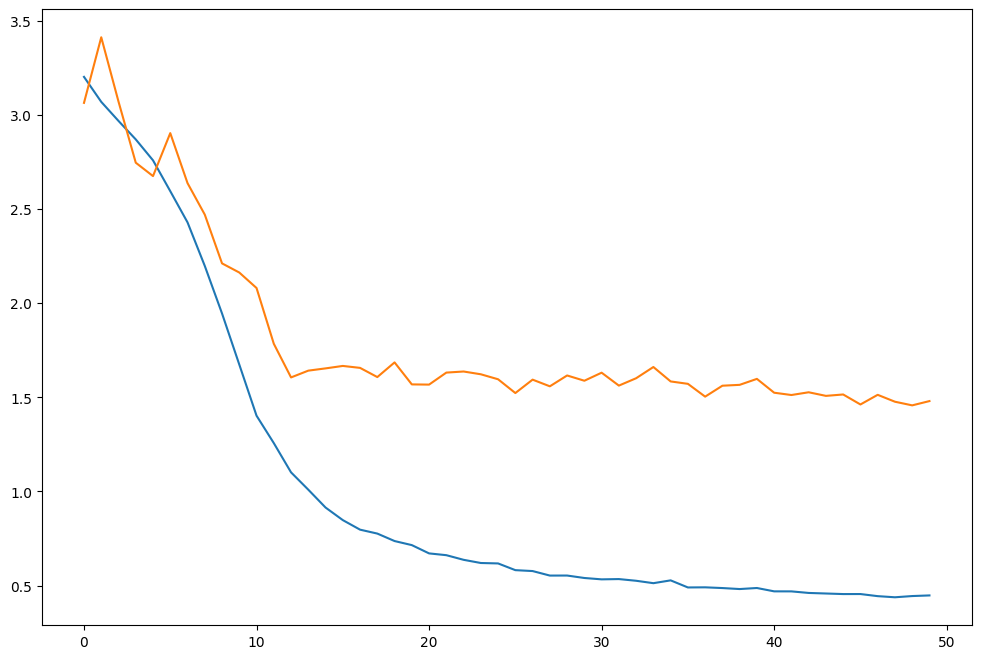

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_loss)
plt.plot(val_loss)